# <center> Recommendation Systems 3693 Final Project
### <center> Deep Neural Networks for YouTube Recommendations
<center> Fall 2023


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# !pip install zipfile36 --quiet
# !pip install uszipcode --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 KB 16.5 MB/s eta 0:00:00


In [4]:
# from zipfile import ZipFile
# 
# with ZipFile("src.zip", 'r') as zObject:
# 	zObject.extractall()

In [18]:
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from src.data.feature_extractor import FeatureExtractor
from src.data.importer import DataImporter
from src.data.ratings_dataset import RatingsDataset
from src.model.candidate_generation import CandidateGeneration
from src.model.popularity import Popularity
from src.trainer import Trainer
from src.utils import get_device
from src.model.candidate_generation_from_transformer import CandidateGenerationT
from src.visualizations import Plotter

<br></br>
## EDA

### Fetch MovieLens100k data

In [6]:
data_importer = DataImporter('http://files.grouplens.org/datasets/movielens/ml-100k.zip')
users_df, movies_df, genres, ratings_df = data_importer.import_data()

### Data exploration

In [7]:
plotter = Plotter()

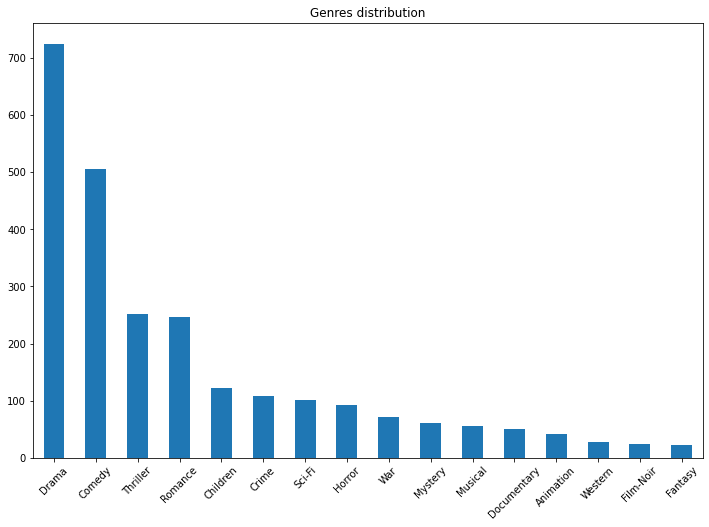

In [8]:
plotter.plot_genres_distribution(movies_df)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


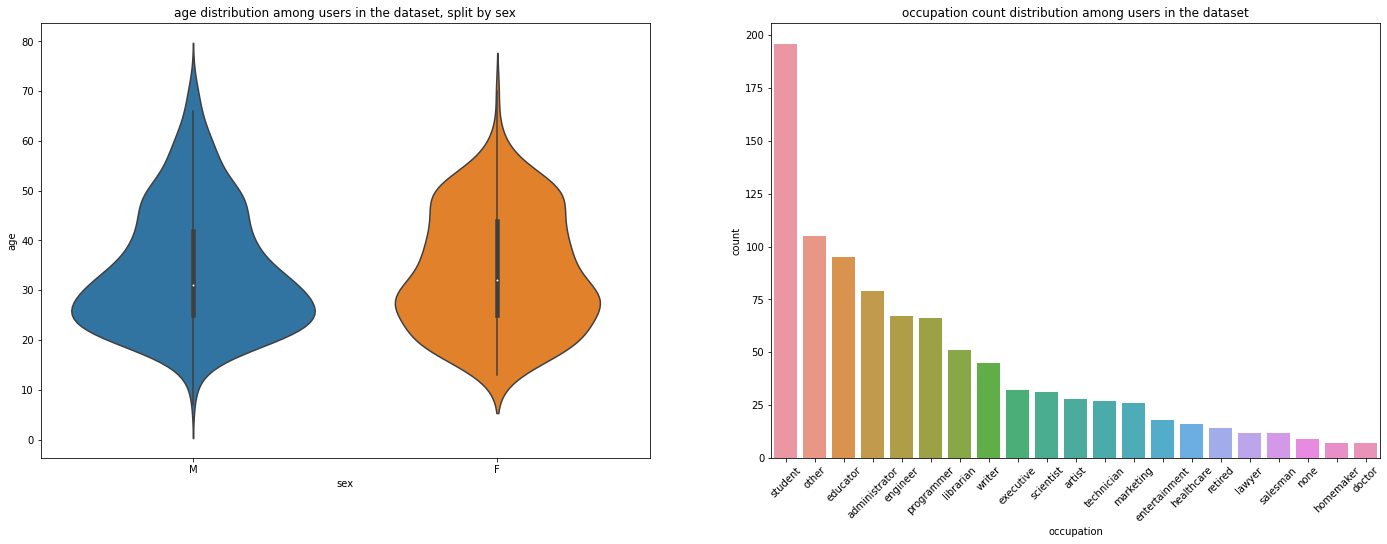

In [9]:
plotter.plot_user_distributions(users_df)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


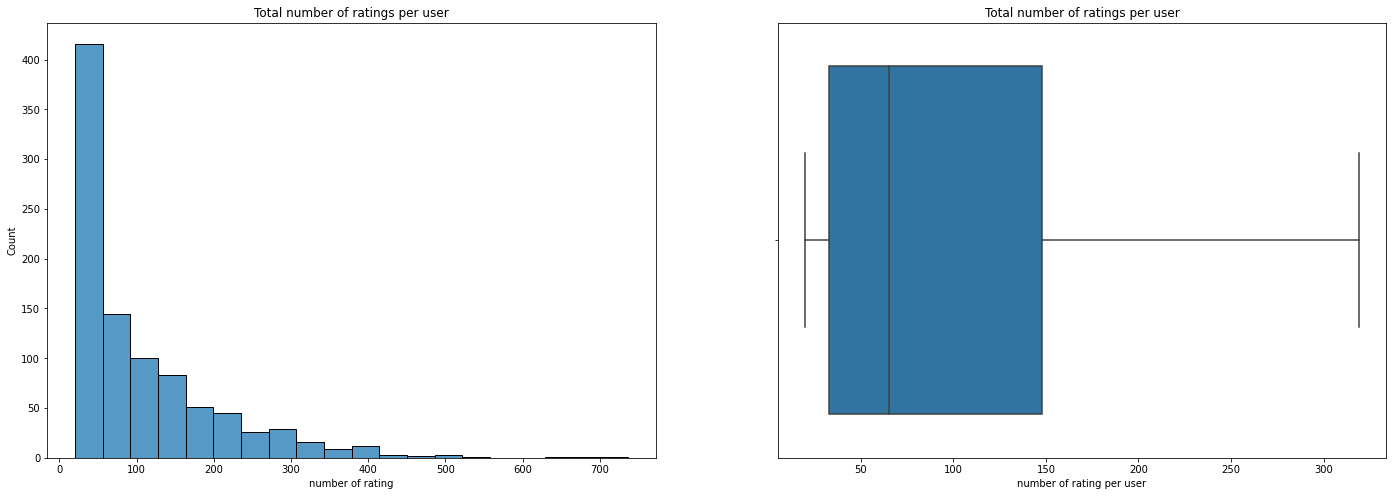

In [10]:
plotter.plot_ratings_distribution(ratings_df)

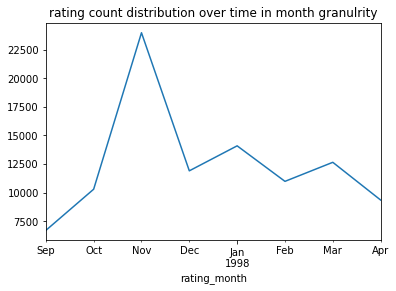

In [11]:
plotter.plot_rating_trends(ratings_df)

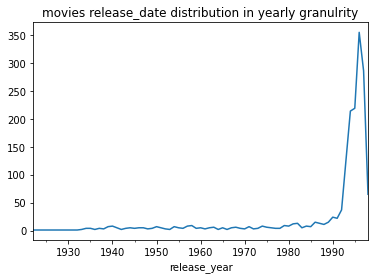

In [12]:
plotter.plot_movies_age_distribution(movies_df)

<br></br>
## Data Preprocessing

### Generate features and create examples df

In [19]:
f_extractor = FeatureExtractor(window_size=16)
examples_df = f_extractor.fit_transform(
    genres=genres,
    movies_df=movies_df,
    users_df=users_df,
    ratings_df=ratings_df
)

One-Hot user occupation matrix shape (943, 21)
One-Hot user gender matrix shape (943, 2)
One-Hot user geo area matrix shape (943, 4)
Using 90 examples per user_id
Using 32 examples per label
Examples shape  (49216, 7)


### Split train/validation examples

In [28]:
train_df, val_df = train_test_split(examples_df)

# Train Loader
train_dataset = RatingsDataset.from_df(train_df)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Validation Loader
val_dataset = RatingsDataset.from_df(val_df)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

<br></br>
## Model Training

Shared Hyperparams

In [32]:
EMBEDDING_DIMS = 256
DENSE_UNITS = 256
USER_DIM = 64
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 10

n_items=movies_df.index.astype(int).max() + 2
n_search_items=len(genres) + 1
n_features=len(examples_df.iloc[0]['features'])
fc_layers=(2048, 1024, 512, 256)

### Train Candidate generation model (original paper)

In [33]:
device = get_device()

cg_model = CandidateGeneration(
    n_items=n_items,
    n_search_items=n_search_items,
    n_features=n_features,
    embedding_dim=EMBEDDING_DIMS,
    fc_layers=fc_layers,
    user_dim=USER_DIM
).to(device)

opt = Adam(cg_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crit = CrossEntropyLoss().to(device)

CUDA is available!  Training on GPU ...


In [34]:
cg_model

CandidateGeneration(
  (positive_embedding): Sequential(
    (0): Embedding(1683, 256)
    (1): EmbeddingsAggregatorLayer()
    (2): L2NormLayer()
  )
  (negative_embedding): Sequential(
    (0): Embedding(1683, 256)
    (1): EmbeddingsAggregatorLayer()
    (2): L2NormLayer()
  )
  (search_embedding): Sequential(
    (0): Embedding(20, 256)
    (1): EmbeddingsAggregatorLayer()
    (2): L2NormLayer()
  )
  (fc): Sequential(
    (0): Linear(in_features=797, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=256, bias=True)
 

In [35]:
trainer = Trainer(cg_model, opt, crit, device)
train_losses, val_losses = trainer.train(train_loader, val_loader, epochs=EPOCHS)

Epoch 1/10, train loss: 7.2988, val loss: 7.1723, time: 4.61s
Epoch 2/10, train loss: 6.8888, val loss: 6.8381, time: 1.14s
Epoch 3/10, train loss: 6.4487, val loss: 6.4848, time: 1.13s
Epoch 4/10, train loss: 5.9755, val loss: 6.1244, time: 1.14s
Epoch 5/10, train loss: 5.4791, val loss: 5.8108, time: 1.28s
Epoch 6/10, train loss: 4.9626, val loss: 5.5116, time: 1.58s
Epoch 7/10, train loss: 4.4393, val loss: 5.2034, time: 1.20s
Epoch 8/10, train loss: 3.9084, val loss: 4.9537, time: 1.36s
Epoch 9/10, train loss: 3.3762, val loss: 4.7335, time: 1.15s
Epoch 10/10, train loss: 2.8417, val loss: 4.5513, time: 1.37s


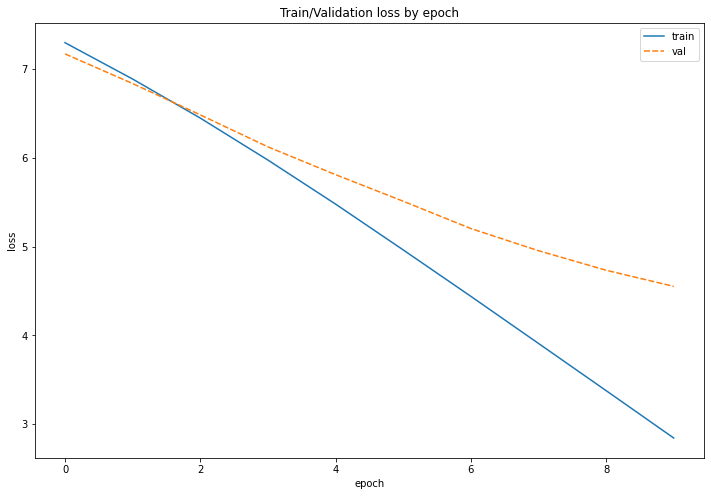

In [36]:
plotter.plot_loss_curves(train_losses, val_losses)

#### Evaluate Model


In [37]:
k = 10
print(f'candidate generation validation mrr @ {k}: ', cg_model.mrr(val_loader, k, device))
print(f'candidate generation validation hit rate @ {k}: ', cg_model.hit_rate(val_loader, k, device))

candidate generation validation mrr @ 10:  0.4225987422466278
candidate generation validation hit rate @ 10:  0.50046875


<br></br>
### POP-based model (Baseline)

In [38]:
pop = Popularity()
pop.fit(ratings_df)

#### Evaluate Model

In [39]:
k = 10
print(f'popularity model validation mrr @ {k}: ', pop.mrr(val_loader, k))
print(f'popularity model validation hit rate @ {k}: ', pop.hit_rate(val_loader, k))

popularity model validation mrr @ 10:  0.00015625000465661288
popularity model validation hit rate @ 10:  0.0009375


<br></br>
### Transformer Based Recommendations

In [40]:
device = get_device()

cgt_model = CandidateGenerationT(
    n_items=n_items,
    n_search_items=n_search_items,
    n_features=n_features,
    embedding_dim=EMBEDDING_DIMS,
    fc_layers=fc_layers,
    user_dim=USER_DIM
).to(device)

opt = Adam(cgt_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crit = CrossEntropyLoss().to(device)

CUDA is available!  Training on GPU ...


In [41]:
cgt_model

CandidateGenerationT(
  (positive_embedding): Sequential(
    (0): Embedding(1683, 256)
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (linear1): Linear(in_features=256, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=256, bias=True)
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (2): EmbeddingsAggregatorLayer()
    (3): L2NormLayer()
  )
  (negative_embedding): Sequential(
    (0): Embedding(1683, 256)
    (1): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
   

In [42]:
trainer = Trainer(cgt_model, opt, crit, device)
train_losses, val_losses = trainer.train(train_loader, val_loader, epochs=EPOCHS)

Epoch 1/10, train loss: 7.1940, val loss: 6.9842, time: 16.26s
Epoch 2/10, train loss: 6.6354, val loss: 6.4563, time: 16.12s
Epoch 3/10, train loss: 6.1113, val loss: 5.9955, time: 16.25s
Epoch 4/10, train loss: 5.6023, val loss: 5.5468, time: 16.58s
Epoch 5/10, train loss: 5.0897, val loss: 5.1443, time: 16.43s
Epoch 6/10, train loss: 4.5848, val loss: 4.7956, time: 16.77s
Epoch 7/10, train loss: 4.0934, val loss: 4.4619, time: 16.69s
Epoch 8/10, train loss: 3.6106, val loss: 4.1332, time: 17.02s
Epoch 9/10, train loss: 3.1509, val loss: 3.8377, time: 17.09s
Epoch 10/10, train loss: 2.7147, val loss: 3.6040, time: 17.24s


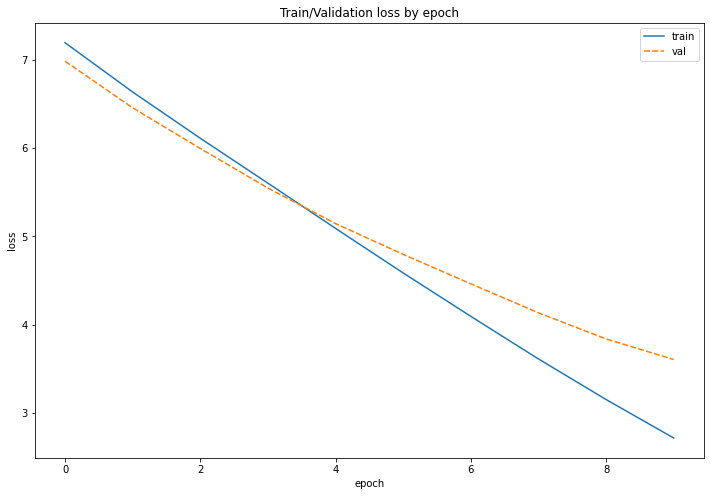

In [43]:
plotter.plot_loss_curves(train_losses, val_losses)

#### Evaluate Model

In [44]:
k = 10
print(f'candidate generation w transformer validation mrr @ {k}: ', cgt_model.mrr(val_loader, k, device))
print(f'candidate generation w transformer validation hit rate @ {k}: ', cgt_model.hit_rate(val_loader, k, device))

candidate generation w transformer validation mrr @ 10:  0.5752656936645508
candidate generation w transformer validation hit rate @ 10:  0.6440625


<br></br>
## Compare models

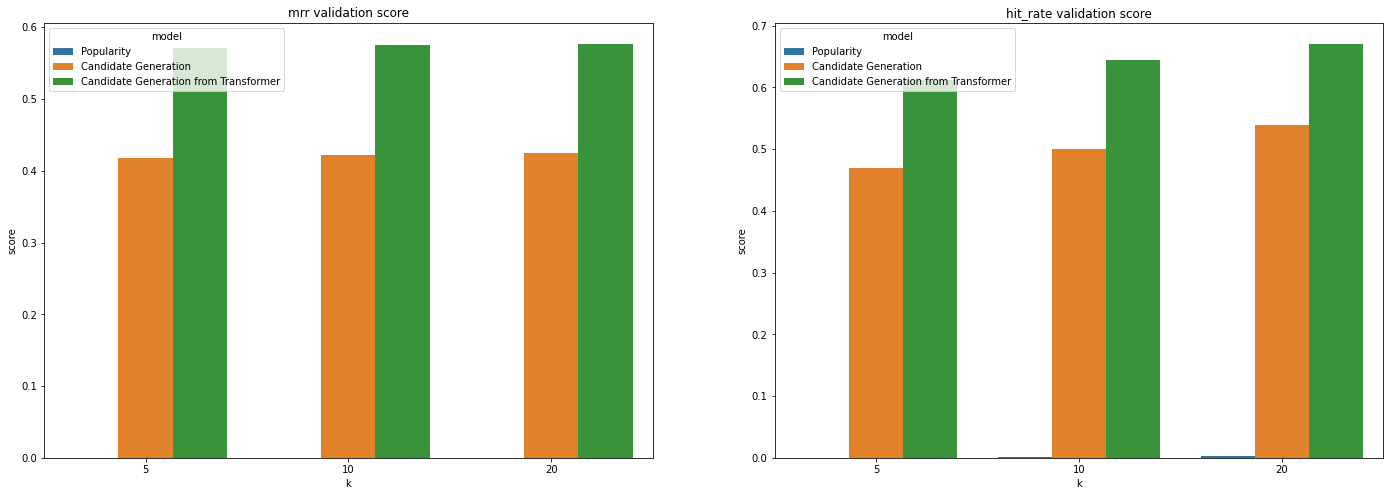

In [45]:
models = [
    (cg_model, 'Candidate Generation'),
    (pop, 'Popularity'),
    (cgt_model, 'Candidate Generation from Transformer')
]

plotter.plot_models_performance(
    models=models,
    val_loader=val_loader,
    device=device
)